SWEET PORTUGAL - Portuguese pastry identifier - Rui Cruzeiro, Jan 2023

Sweet Portugal is a tool created for my personal portfolio. It consists on a study of a Convolutional Neural Network that will identify 5 different types of Portuguese pastries and return their name, recipe, and calorie intake. It can be scaled to identify much more; however, that would require an extensive data gathering operation that lies outside of the scope of this project. It would nonetheless be some delicious data mining!

(Special thanks to Mandy from deeplizard - great tutorials on YouTube)

NOTEBOOK 2/2 - PREPROCESSING & MODELING

In [196]:
from tensorflow.io import read_file
from tensorflow.image import decode_jpeg
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, layers, applications
from tensorflow.math import confusion_matrix as confusion_matrix_tf
import os
import glob
import shutil
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Getting the data

First, let's get the names of the pastries we have on our dataset. Those will be our target labels/classes.

In [2]:
### so far, these are the pastries we have 50 pictures of --- all stored in the raw_data folder ###

available_pastries = [subdir for subdir in os.listdir('raw_data') if not subdir.startswith('.')]
available_pastries.sort()
available_pastries

['bolo_arroz', 'brigadeiro', 'ovos_moles', 'pastel_nata', 'pastel_tentugal']

We'll go through all the images we have and find the smallest dimension. That will be our target size for the preprocessing.

In [3]:
### gets the minimum dimension from all images --- that will be the target_size ###

imgs = []
y = []
width_list = []
height_list = []

for pastry_name in available_pastries:
    for filename in os.scandir(os.path.join('raw_data', pastry_name)):
        file_name, file_extension = os.path.splitext(filename.path)
        if filename.is_file() and file_extension == '.jpeg':

            # get image dimensions
            height, width = decode_jpeg(read_file(filename.path), 3).shape[:2]
            width_list.append(width)
            height_list.append(height)

# find smallest dimension from all files 
min_dim = min(min(height_list), min(width_list))

# give feedback
print('Minimum image height: ' +  str(min(height_list)))
print('Minimum image width: ' + str(min(width_list))) 
print('--> Target size: ' + str(min_dim)) 

2023-01-30 15:15:50.671744: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-30 15:16:02.061563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Minimum image height: 156
Minimum image width: 200
--> Target size: 156


Let's randomly split the images into train and test sets. On the first notebook in this repository ("01_Data_Augmentation.ipynb"), we created new images from the original ones and we now have 130 images per pastry. Let's use 100 for training and 30 for testing.

In [130]:
# Check if raw_data is the current working directory

os.getcwd()

'/Users/ruicruzeiro/code/sweet_portugal/sweet_portugal/raw_data'

In [133]:
# Randomly moves images to train and test folders; if this is already done, it does nothing

if os.path.isdir('train/bolo_arroz') is False:
    os.makedirs('train/bolo_arroz')
    os.makedirs('train/brigadeiro')
    os.makedirs('train/ovos_moles')   
    os.makedirs('train/pastel_nata')
    os.makedirs('train/pastel_tentugal')
    os.makedirs('test/bolo_arroz')
    os.makedirs('test/brigadeiro')
    os.makedirs('test/ovos_moles')   
    os.makedirs('test/pastel_nata')
    os.makedirs('test/pastel_tentugal')
    
    for c in random.sample(glob.glob('bolo_arroz/*'), 100):
        shutil.move(c, 'train/bolo_arroz')
    for c in random.sample(glob.glob('brigadeiro/*'), 100):
        shutil.move(c, 'train/brigadeiro')
    for c in random.sample(glob.glob('ovos_moles/*'), 100):
        shutil.move(c, 'train/ovos_moles')
    for c in random.sample(glob.glob('pastel_nata/*'), 100):
        shutil.move(c, 'train/pastel_nata')
    for c in random.sample(glob.glob('pastel_tentugal/*'), 100):
        shutil.move(c, 'train/pastel_tentugal')
    for c in random.sample(glob.glob('bolo_arroz/*'), 30):
        shutil.move(c, 'test/bolo_arroz')
    for c in random.sample(glob.glob('brigadeiro/*'), 30):
        shutil.move(c, 'test/brigadeiro')
    for c in random.sample(glob.glob('ovos_moles/*'), 30):
        shutil.move(c, 'test/ovos_moles')
    for c in random.sample(glob.glob('pastel_nata/*'), 30):
        shutil.move(c, 'test/pastel_nata')
    for c in random.sample(glob.glob('pastel_tentugal/*'), 30):
        shutil.move(c, 'test/pastel_tentugal')

### Preprocessing

We'll apply the Keras ImageDataGenerator to preprocess our images in one go.

In [135]:
# Preprocessing using Keras ImageDataGenerator

train_batches = ImageDataGenerator(preprocessing_function=applications.vgg16.preprocess_input) \
    .flow_from_directory(directory='train', target_size=(min_dim, min_dim), classes=available_pastries, batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=applications.vgg16.preprocess_input) \
    .flow_from_directory(directory='test', target_size=(min_dim, min_dim), classes=available_pastries, batch_size=10)

Found 500 images belonging to 5 classes.
Found 150 images belonging to 5 classes.


We can plot some resulting processed images from one ImageDataGenerator batch.

In [136]:
imgs, labels = next(train_batches)

In [137]:
def plot_images(images_array):
    """
    Plots preprocessed images
    """
    
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_array, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

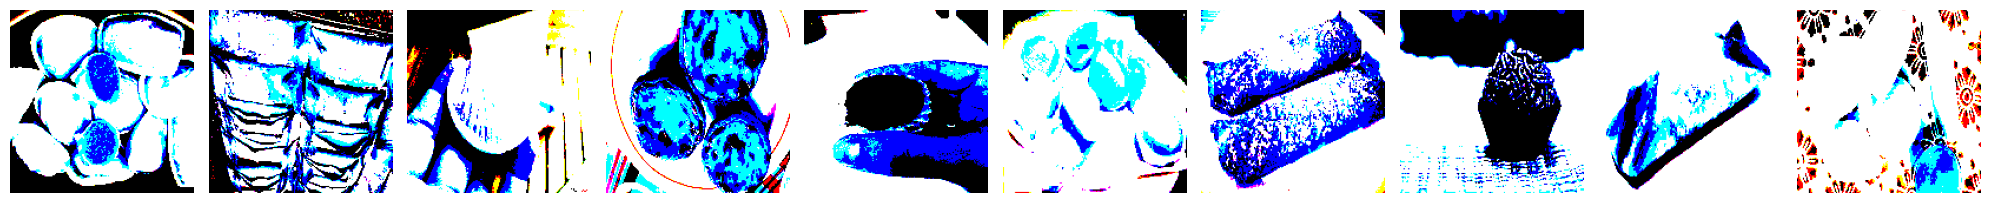

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]]


In [138]:
# Plot proprocessed images and corresponding labels

plot_images(imgs)
print(labels);

### Modeling

Now, we'll define the architecture of our CNN. This is an ever-ongoing process as we can finetune the architecture whenever we see fit.

In [146]:
def initialize_model():
    
    model = Sequential()

    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(min_dim, min_dim, 3)))
    model.add(layers.MaxPool2D(pool_size=(4,4)))
    
    model.add(layers.Conv2D(32, kernel_size=(3, 3)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(len(available_pastries), activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model  

Time to instantiate! Let's fit the model and see how well it performs. We are using `steps_per_epoch=50` since we have 50 batches with 10 images each, for a total of 500 images.

In [147]:
model = initialize_model()

es = EarlyStopping(
              patience=10,
              monitor='accuracy',
              verbose=1)

history = model.fit(
              x=train_batches,
              epochs=10,
              steps_per_epoch=50,
              callbacks=[es],
              verbose=1)

Epoch 1/10
50/50 [==============================] - 17s 328ms/step - loss: 32.7773 - accuracy: 0.4580
Epoch 2/10
50/50 [==============================] - 17s 323ms/step - loss: 2.7431 - accuracy: 0.7940
Epoch 3/10
50/50 [==============================] - 17s 339ms/step - loss: 0.8261 - accuracy: 0.9060
Epoch 4/10
50/50 [==============================] - 17s 334ms/step - loss: 0.4833 - accuracy: 0.9300
Epoch 5/10
50/50 [==============================] - 17s 338ms/step - loss: 0.2269 - accuracy: 0.9720
Epoch 6/10
50/50 [==============================] - 17s 335ms/step - loss: 0.2717 - accuracy: 0.9560
Epoch 7/10
50/50 [==============================] - 17s 335ms/step - loss: 0.2611 - accuracy: 0.9720
Epoch 8/10
50/50 [==============================] - 17s 334ms/step - loss: 0.3402 - accuracy: 0.9520
Epoch 9/10
50/50 [==============================] - 18s 350ms/step - loss: 0.2981 - accuracy: 0.9460
Epoch 10/10
50/50 [==============================] - 18s 356ms/step - loss: 0.4728 - accur

### Predicting

Let's get some predictions out of our model. The `predict` method used below has `steps=15` since we have 15 batches with 10 images each, for a total of 150 images.

In [149]:
predictions = model.predict(
                x=test_batches,
                steps=15)

predictions

15/15 [==============================] - 6s 402ms/step


array([[4.19658065e-28, 8.13286831e-36, 4.81740343e-30, 1.00000000e+00,
        4.22587539e-31],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 2.78112168e-29,
        0.00000000e+00],
       [3.83100938e-04, 4.88505171e-30, 1.43258804e-25, 9.99616861e-01,
        0.00000000e+00],
       [1.64016070e-20, 3.06807154e-35, 1.00000000e+00, 6.12466621e-23,
        8.44082724e-21],
       [1.50593827e-02, 0.00000000e+00, 0.00000000e+00, 9.84940588e-01,
        9.13005634e-37],
       [1.00000000e+00, 0.00000000e+00, 8.68266160e-36, 1.92043994e-21,
        0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.65923924e-11,
        6.06169229e-33],
       [8.58536367e-11, 1.00000000e+00, 1.58782909e-38, 6.30691335e-26,
        3.95496179e-12],
       [3.57335688e-24, 0.00000000e+00, 1.00000000e+00, 1.41147722e-19,
        8.21339382e-30],
       [2.19114214e-01, 1.24901162e-16, 1.93162377e-05, 7.80622661e-01,
        2.43842340e-04],
       [9.99873519e-01, 3.2427

The content of "predictions" is hard to read. Let's clean it up.

In [154]:
np.round(predictions)

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0.

### Viewing the results

Visualizing the test set...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

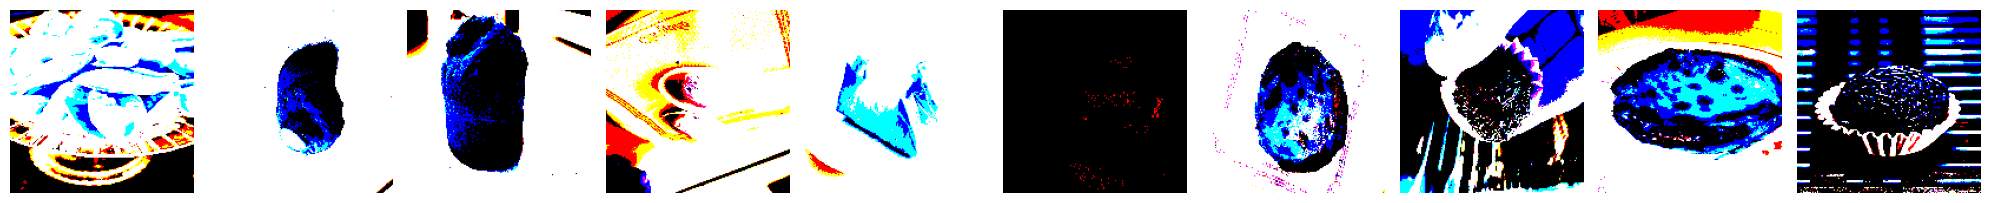

[[0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]]


In [152]:
test_imgs, test_labels = next(test_batches)

plot_images(test_imgs)
print(test_labels);

We need to take a look into the classes of the test batches before plotting.

In [168]:
test_batches.class_indices

{'bolo_arroz': 0,
 'brigadeiro': 1,
 'ovos_moles': 2,
 'pastel_nata': 3,
 'pastel_tentugal': 4}

Creating a confusion matrix using TensorFlow:

In [185]:
cm_tf = confusion_matrix_tf(
    labels=test_batches.classes,
    predictions=np.argmax(predictions, axis=-1)
)

In [187]:
cm_tf

<tf.Tensor: shape=(5, 5), dtype=int32, numpy=
array([[10,  6,  5,  7,  2],
       [12,  6,  5,  5,  2],
       [10,  3,  5,  7,  5],
       [16,  2,  3,  7,  2],
       [10,  9,  4,  5,  2]], dtype=int32)>

Defining a function to visualize the results:

In [200]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    Prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix without normalization')
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else "black")
                
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Let's plot the results:

Confusion matrix without normalization
[[10  6  5  7  2]
 [12  6  5  5  2]
 [10  3  5  7  5]
 [16  2  3  7  2]
 [10  9  4  5  2]]


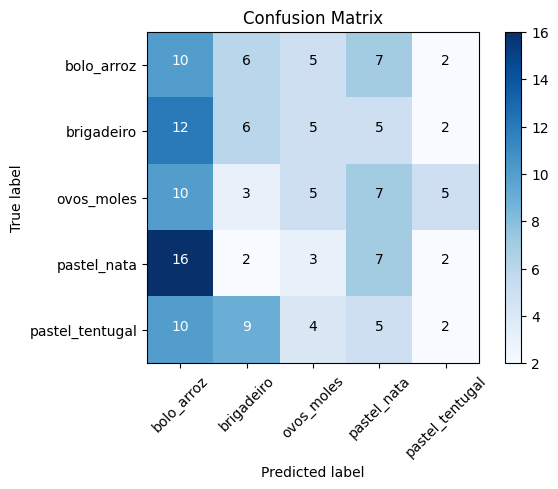

In [201]:
# Following the order of the class indices 
cm_plot_labels = ['bolo_arroz', 'brigadeiro', 'ovos_moles', 'pastel_nata', 'pastel_tentugal']

plot_confusion_matrix(cm=cm, classes=cm_plot_labels);

We can see that the model is not predicting very well on the test set despite having found an accuracy of 95.6% on our last fitting epoch. This means we're overfitting and that the model needs improvement.